In [1]:
from __future__ import print_function
import numpy as np
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import range
from data_utils import get_CIFAR10_data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import os

In [2]:
tr = transforms.Compose([
        transforms.Scale(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [12]:
trset = datasets.CIFAR10('data', train=True, transform=tr, target_transform=None, download=False)
tsset = datasets.CIFAR10('data', train=False, transform=tr, target_transform=None, download=False)
dsets = {'train':trset, 'test':tsset}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=5,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'test']}

In [13]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_classes = classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(len(trset))
print(len(tsset))

50000
10000


In [5]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


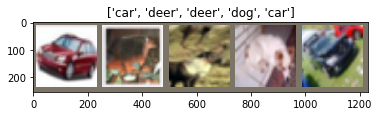

In [33]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=6, padding=20)

imshow(out, title=[dset_classes[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25, print_every=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        p = 0
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data
                
                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
                if (p % print_every == 0):
                    print("loss : ", loss.data[0])
                    print("corrects : ", torch.sum(preds == labels.data))
                
                p += 1
                
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model


In [8]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [15]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters())

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25, print_every=100)

Epoch 0/24
----------
LR is set to 0.001
loss :  2.394974708557129
corrects :  4
loss :  1.1819303035736084
corrects :  23
loss :  0.9752801060676575
corrects :  18
loss :  0.9298704266548157
corrects :  23
loss :  0.8424128293991089
corrects :  21
loss :  0.8896394371986389
corrects :  24
loss :  0.7168756723403931
corrects :  25
loss :  0.45215120911598206
corrects :  28
loss :  0.6549448370933533
corrects :  25
loss :  0.5728098154067993
corrects :  27
loss :  0.748691976070404
corrects :  23
loss :  0.7030200958251953
corrects :  24
loss :  0.855570912361145
corrects :  23
loss :  1.1314446926116943
corrects :  17
loss :  0.6458859443664551
corrects :  25
loss :  0.6711001396179199
corrects :  24
train Loss: 0.0250 Acc: 0.7341
loss :  0.7283772826194763
corrects :  24
loss :  0.6811052560806274
corrects :  24
loss :  0.6804729700088501
corrects :  25
test Loss: 0.0207 Acc: 0.7724

Epoch 1/24
----------
loss :  0.8973548412322998
corrects :  24
loss :  0.5001348257064819
corrects : 

loss :  0.6880407333374023
corrects :  24
loss :  0.3227471113204956
corrects :  28
loss :  0.9636462330818176
corrects :  21
loss :  0.7547397613525391
corrects :  25
loss :  0.5022740960121155
corrects :  27
loss :  0.7852156162261963
corrects :  25
loss :  0.7744991779327393
corrects :  22
loss :  0.4002630114555359
corrects :  28
loss :  0.36460718512535095
corrects :  27
loss :  0.5678536891937256
corrects :  26
loss :  0.6739546060562134
corrects :  25
train Loss: 0.0172 Acc: 0.8099
loss :  0.72272789478302
corrects :  24
loss :  0.7021666765213013
corrects :  25
loss :  0.44993704557418823
corrects :  28
test Loss: 0.0175 Acc: 0.8095

Epoch 10/24
----------
loss :  0.7091973423957825
corrects :  26
loss :  0.4471084773540497
corrects :  27
loss :  0.5390903949737549
corrects :  29
loss :  0.44042718410491943
corrects :  26
loss :  0.6371080279350281
corrects :  27
loss :  0.5551627278327942
corrects :  25
loss :  0.5865384340286255
corrects :  23
loss :  0.3427000939846039
corre

loss :  0.4929594099521637
corrects :  24
loss :  0.48483648896217346
corrects :  26
loss :  0.8108277320861816
corrects :  22
loss :  0.47872841358184814
corrects :  25
loss :  0.5357922911643982
corrects :  24
loss :  0.6243718266487122
corrects :  24
train Loss: 0.0169 Acc: 0.8124
loss :  0.5830498337745667
corrects :  25
loss :  0.7235655188560486
corrects :  25
loss :  0.5842693448066711
corrects :  23


Process Process-155:
Process Process-154:
Process Process-156:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sreekar/miniconda3/envs/deep/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/sreekar/miniconda3/envs/deep/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/sreekar/miniconda3/envs/deep/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sreekar/miniconda3/envs/deep/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sreekar/miniconda3/envs/deep/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/sreekar/miniconda3/envs/deep/lib/python3.5/multiprocessing/process.py", line 249,

KeyboardInterrupt: 

In [13]:
f = open("soft.pkl", "bw")
torch.save(model_conv.state_dict(), f)
f.close()

In [11]:
f = open('soft.pkl', 'rb')
model_conv.load_state_dict(torch.load(f))
f.close()

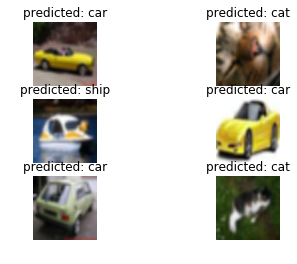

In [35]:
visualize_model(model_conv)

plt.ioff()
plt.show()